In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Osc:
    def __init__(self, alpha):
        self.alpha = alpha

    def f(self, t):
        return alpha
    
    def V(self, q, t):
        return q**2/2
        
    def Vq(self, q, t):
        return q

In [4]:
dt = 0.0001
t0 = 0.0
tf = 50.0

tspan = np.arange(t0, tf, dt)
tspansmall = np.arange(t0, tf, dt/8)

upper_error_bound = lambda a, dt, p0, q0: dt**3/24 * abs(-4*q0*a+p0*(-4+a**2))
upper_error_bound_p = lambda a, dt, p0, q0: (dt**3)/24*abs(4*p0*a +q0*(2+a**2))

exact = lambda a, t: np.real((np.exp(-1/2*(np.lib.scimath.sqrt(a**2 - 4) + a)*t)*(
        (np.lib.scimath.sqrt(a**2 - 4) + 2)*np.exp(np.lib.scimath.sqrt(a**2 - 4)*t)
        + a*(np.exp(np.lib.scimath.sqrt(a**2 - 4)*t) - 1) + np.lib.scimath.sqrt(a**2 - 4) - 2))
                             /(2*np.lib.scimath.sqrt(a**2 - 4)))

exactp = lambda a, t: np.real((1/(2*np.lib.scimath.sqrt(-4+a**2)))*(np.exp(-t/2 *(a+np.lib.scimath.sqrt(-4+a**2)))
                                                                   *(2+a+np.lib.scimath.sqrt(-4+a**2)-(2+a)
                                                                    *np.exp(t*np.lib.scimath.sqrt(-4+a**2))+
                                                                    np.lib.scimath.sqrt(-4+a**2)*
                                                                     np.exp(t*np.lib.scimath.sqrt(-4+a**2)))))


In [ ]:
steps = len(tspan)
err = np.empty([steps], dtype=np.float64)

for (alpha, p0, q0) in [(0.125, 1.0, 1.0)]:#,(0.2, 1.0, 1.0),(0.5, 1.0, 1.0), (1, 1.0, 1.0), (5, 1.0, 1.0)]:
    do = Osc(alpha)
    plt.figure(figsize=(15,10))
#    plt.suptitle(f"$\\gamma = {do.alpha}$, $(p_0, q_0) = {p0}, {q0}$")
    plt.suptitle(f"$\\gamma = {do.alpha}$, $(p_0, q_0) = {p0}, {q0}$, $\\tau = {dt}$",size=16)

    plt.subplot(221)
    
    sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
    solsmall, _, _ = ic.integrate(ic.step, do, tspansmall, p0, q0, 0.0)
    
    ex = lambda tspan: exact(alpha, tspan)
        
    plt.plot(tspan, ex(tspan),label="exact solution")
    plt.plot(tspan, sol[:,1], label="approximated solution")
    plt.legend()



    plt.subplot(222)
#    plt.plot(tspan, abs(sol[:,0]-ex(tspan)))
    plt.plot(tspan, (abs(sol[:,1]-ex(tspan))), label="Real Error")
    plt.plot(tspan, np.cumsum([upper_error_bound(alpha, dt, p0, q0) for p0, q0 in sol[:]]), label="Modified Hamiltonian Error")
#    plt.axhline(y=upper_error_bound(alpha, dt, p0, q0), c='r')
#    plt.ylim((pow(10,-4),pow(10,1)) )    
    plt.legend()
    plt.yscale('log')

    plt.subplot(223)
    
    ex1 = lambda tspan: exactp(alpha, tspan)
        
    plt.plot(tspan, ex1(tspan),label="exact solution")
    plt.plot(tspan, sol[:,0], label="approximated solution")
    plt.legend()

    
    plt.subplot(224)
#    plt.plot(tspan, abs(sol[:,0]-ex(tspan)))
    plt.plot(tspan, (abs(sol[:,0]-ex1(tspan))), label="Real Error")
    plt.plot(tspan, np.cumsum([upper_error_bound_p(alpha, dt, p0, q0) for p0, q0 in sol[:]]), label="Modified Hamiltonian Error")
#    plt.axhline(y=upper_error_bound(alpha, dt, p0, q0), c='r')
#    plt.ylim((pow(10,-4),pow(10,1)) )    
    plt.legend()
    plt.yscale('log')
    
#    plt.subplot(222)
#    plt.title(f"dt = {dt/8}")
#    tspansmall = np.arange(t0, tf, dt/8)
#    plt.plot(tspansmall, ex(tspansmall))
#    plt.plot(tspansmall, solsmall[:,1])
    
    
#    plt.subplot(224)
#    plt.plot(tspansmall, abs(solsmall[:,1]-ex(tspansmall)))
#    plt.plot(tspansmall, np.cumsum(abs(solsmall[:,1]-ex(tspansmall))))
#    plt.plot(tspansmall, np.cumsum([upper_error_bound(alpha, dt, p0, q0) for p0, q0 in solsmall[:]]))
#    plt.axhline(y=upper_error_bound(alpha, dt, p0, q0), c='r')
#    plt.yscale('log')
#    plt.subplot(325)
#    plt.plot(ex(tspan),ex1(tspan))
#    plt.plot(sol[:,1],sol[:,0])
             
plt.show()

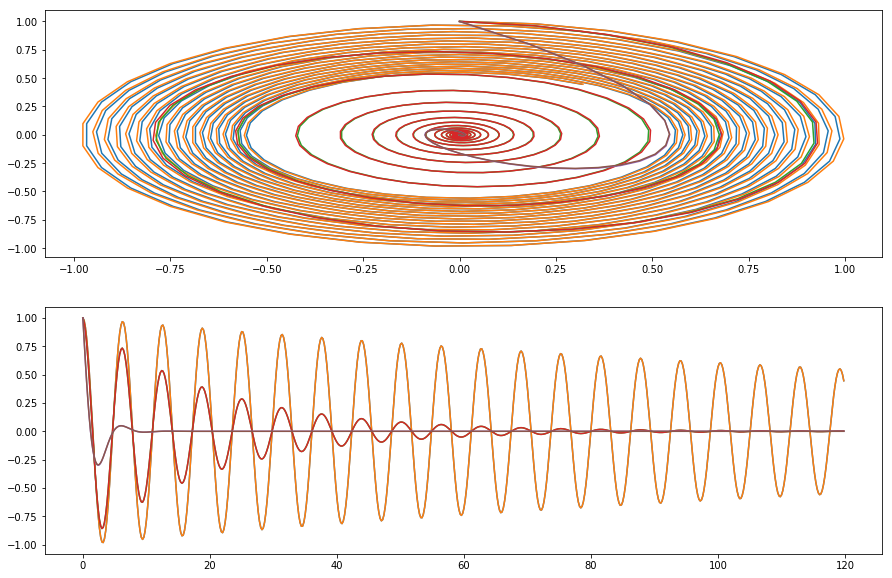

In [12]:
dt = 0.2
t0 = 0.0
tf = 120.0

tspan = np.arange(t0, tf, dt)

plt.figure(figsize=(15,10))

plt.subplot(211)
for (alpha, p0, q0) in [(0.01, 1.0, 0.0), (0.1, 1.0, 0.0), (1.0, 1.0, 0.0)]:
    do = Osc(alpha)
    
    sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
    soll, _, _ = ic.integrate(ic.variational_step, do, tspan, p0, q0, 0.0)

    plt.plot(sol[:,1], sol[:,0])
    plt.plot(soll[:,1], soll[:,0])
    
plt.subplot(212)
for (alpha, p0, q0) in [(0.01, 1.0, 0.0), (0.1, 1.0, 0.0), (1.0, 1.0, 0.0)]:
    # FIXME: pointless to do it twice...
    sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
    soll, _, _ = ic.integrate(ic.variational_step, do, tspan, p0, q0, 0.0)
        
    plt.plot(tspan, sol[:,0])
    plt.plot(tspan, soll[:,0])
plt.show()

In [59]:
err[0]+err[1]-err[2]

0.00040972773175229973

In [49]:
ex1(0.125,0)

TypeError: <lambda>() takes 1 positional argument but 2 were given